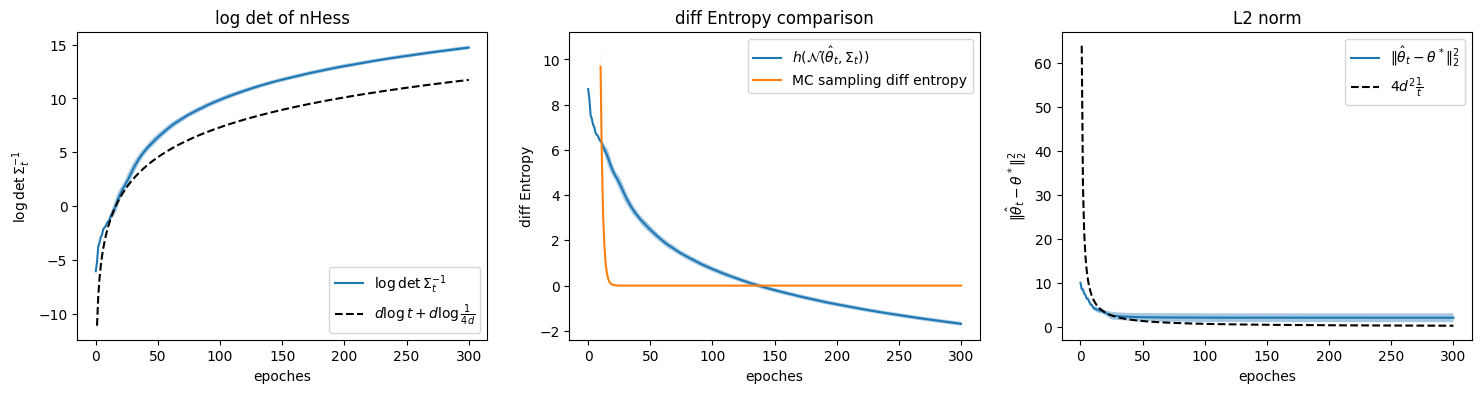

In [149]:
from utils.base import *
import numpy as np
import matplotlib.pyplot as plt
import os

def list_files_in_directory(directory_path):
    files = []
    for entry in os.listdir(directory_path):
        full_path = os.path.join(directory_path, entry)
        if os.path.isfile(full_path):
            files.append(full_path)
    return files

# log determinant 
# ent 
# log determinant_ent
# L2 norm
# --> 이 정도하면 될 것 같음!!

def get_result(directory_path, true_theta_path) :
    files = list_files_in_directory(directory_path)
    true_theta = np.load(true_theta_path)
    Datas = []
    for file in files :
        Data = np.load(file,allow_pickle=True)
        dim = len(Data.item().get('nHess')[0])

        logdet = np.log(np.linalg.det(Data.item().get('nHess')))
        approx_diff_ent = 0.5 * (dim * np.log(2 * np.pi * np.e) - logdet)
        diff_ent = np.array(Data.item().get('ent'))
        L2_norm = np.sqrt(np.sum(np.array(Data.item().get('MAP') - true_theta) ** 2,axis=1))
        
        Datas.append([logdet, approx_diff_ent, diff_ent, L2_norm])
    
    Datas = np.array(Datas)
    
    log_det_mean, log_det_std = np.mean(Datas[:, 0, :],axis=0), np.std(Datas[:, 0, :],axis=0)
    approx_diff_ent_mean, approx_diff_ent_std = np.mean(Datas[:, 1, :],axis=0), np.std(Datas[:, 1, :],axis=0)
    diff_ent_mean, diff_ent_std = np.mean(Datas[:, 2, :],axis=0), np.std(Datas[:, 2, :],axis=0)
    L2_norm_mean, L2_norm_std = np.mean(Datas[:, 3, :],axis=0), np.std(Datas[:, 3, :],axis=0)

    return log_det_mean, log_det_std, approx_diff_ent_mean, approx_diff_ent_std, diff_ent_mean, diff_ent_std, L2_norm_mean, L2_norm_std

def plot_result(model_name,dim = 4, alpha_LN = 10) :

    directory_path = './' + model_name + '_synthetic_result'
    true_theta_path = './params_synthetic/true_theta_4dim_' + model_name + '.npy'
    log_det_mean, log_det_std, approx_diff_ent_mean, approx_diff_ent_std, diff_ent_mean, diff_ent_std, L2_norm_mean, L2_norm_std = get_result(directory_path, true_theta_path)
    
    plt.figure(figsize= (18,4)) 
    
    plt.subplot(1,3,1)
    plt.plot(log_det_mean, label=r"$\log\det \Sigma_t^{-1}$")
    plt.fill_between([t for t in range(len(log_det_mean))],log_det_mean - log_det_std, log_det_mean + log_det_std, alpha = 0.4)  

    if model_name == 'LN' :
        plt.plot(np.array([t for t in range(1, len(log_det_mean))]), 
             dim * np.log(np.array([t for t in range(1, len(log_det_mean))])) + dim*np.log(alpha_LN**2 / (4*dim)), linestyle = '--', color='black',
             label = r'$d\log t + d\log\frac{\alpha^2}{4d}$')
    else :
        plt.plot(np.array([t for t in range(1, len(log_det_mean))]), 
             dim * np.log(np.array([t for t in range(1, len(log_det_mean))])) + dim*np.log(1 / (4*dim)), linestyle = '--', color='black',
             label = r'$d\log t + d\log\frac{1}{4d}$')
        
    
    plt.xlabel("epoches")
    plt.ylabel(r"$\log\det \Sigma_t^{-1}$")
    plt.title("log det of nHess")
    
    plt.legend()

    plt.subplot(1,3,2)
    plt.plot(approx_diff_ent_mean, label = r'$h(\mathcal{N}(\hat{\theta}_t,\Sigma_t))$')
    plt.fill_between([t for t in range(len(approx_diff_ent_mean))],approx_diff_ent_mean - approx_diff_ent_std, approx_diff_ent_mean + approx_diff_ent_std, alpha = 0.4)  

    if model_name == 'LN' :
        m = 5
    else :
        m = 10
    
    plt.plot([t + m for t in range(len(diff_ent_mean[m:]))], diff_ent_mean[m:], label = 'MC sampling diff entropy')
    plt.fill_between([t + m for t in range(len(diff_ent_mean[m:]))], diff_ent_mean[m:] - diff_ent_std[m:], diff_ent_mean[m:] + diff_ent_std[m:], alpha = 0.4)  
    plt.xlabel("epoches")
    plt.ylabel("diff Entropy")
    plt.title("diff Entropy comparison")
    plt.legend()

    plt.subplot(1,3,3)
    plt.plot(L2_norm_mean, label = r"$\Vert \hat{\theta}_t - \theta^* \Vert_2^2$")
    plt.fill_between([t for t in range(len(L2_norm_mean))],L2_norm_mean - L2_norm_std, L2_norm_mean + L2_norm_std, alpha = 0.4)  

    if model_name == 'LN' :
        plt.plot(np.array([t for t in range(1, len(L2_norm_mean))]), 
             (4 * ((dim/alpha_LN) **2)) * (1 / np.array([t for t in range(1, len(log_det_mean))])), linestyle = '--', color='black',
             label = r'$\frac{4d^2}{\alpha^2}\frac{1}{t}$')
    else :
        plt.plot(np.array([t for t in range(1, len(L2_norm_mean))]), 
             (4 * (dim **2)) * (1 / np.array([t for t in range(1, len(log_det_mean))])), linestyle = '--', color='black',
             label = r'$4d^2\frac{1}{t}$')
        

    plt.xlabel("epoches")
    plt.ylabel(r"$\log\det \Sigma_t^{-1}$")
    plt.title("log det of nHess")

    plt.xlabel("epoches")
    plt.title("L2 norm")
    plt.ylabel(r"$\Vert \hat{\theta}_t - \theta^* \Vert_2^2$")
    plt.legend()

    plt.savefig(model_name + '.pdf')

plot_result('MIRT')